![alt text](https://zewailcity.edu.eg/main/images/logo3.png)
# Cie 425 A3
### Ezzat Esam Eisawy  201901195

In [102]:
from PIL import Image
from IPython.display import Image as Img
import numpy as np
from numpy import zeros
from matplotlib import image
from matplotlib import pyplot as plt
from numpy import cos
from numpy.core.umath import pi
from numpy import uint8
from numpy import asarray
from queue import PriorityQueue

#### Importing the image

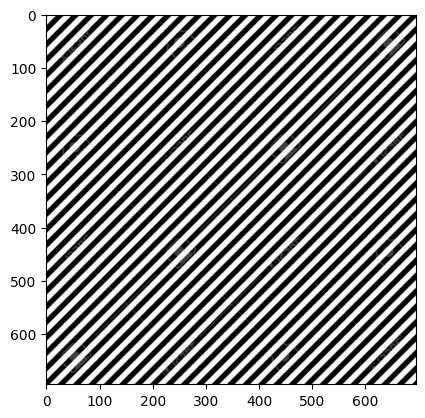

In [103]:
img = Image.open('Fig2.jpg')
plt.imshow(img)

#### Image deviding functions
##### The following function are required to devide and combine the image to the 8x8 blocks
* In case the image is greater than an integer multiple of 8x8 , It's cropped to the nearest 8x8 resolution scale

In [104]:
def devide_image(img ) :
    ''' Takes an image and devides it to n*m sub images... n and m are the nearest integer scale of 8 x 8
    returns the sub images (as an array), n and and m'''
    img_array = asarray(img)
    img_array = img_array[:,:,1]
    n,m = img_array.shape
    n ,m=  int(n/8) ,int(m/8)
    res_devided = []
    for i in range(n) :
        for j in range(m) :
            res_devided.append(img_array[i*8:(i+1)*8,j*8:(j+1)*8])
    return res_devided ,n ,m

def combine_image(blocks ,n,m) :
    ''' Takes an array of 8x8 blocks to be combined to a nx8,mx8 image'''
    final_image = zeros((n*8,m*8))
    idx =0
    for i in range(n) :
        for j in range(m) :
            final_image[i*8:(i+1)*8,j*8:(j+1)*8] = blocks[idx]
            idx +=1
    return final_image.astype(uint8)
    

#### DCT functions
* The basis matrices are similar for all blocks
* We create the basis matrices and store it inside another matrix so we can access it in each block instead of creating a new basis each block
* This modifications reduces processing time

In [105]:
def create_basis_mat() :
    ''' Creating a matrix containing another basis matrices for all u and v to be used in block DCT'''
    basis_mat = np.empty(shape=(8,8) ,dtype= object)
    for u in range(8) :
        for v in range(8) :
            # for x in range(8) :
            #     for y in range(8) :
            #         basis[x,y] = (cos((1/16)* (2*x +1)*u*pi) *  cos((1/16)* (2*y +1)*v*pi))
            ''' The next line is similar to the previous two for loops'''
            basis = np.fromfunction(lambda x, y: (cos((1/16)* (2*x +1)*u*pi) *  cos((1/16)* (2*y +1)*v*pi)), (8, 8), dtype=float)
            basis_mat[u,v] = basis
    return basis_mat

def dct8_image(image_part : np.array ,basis_mat :np.array = None) :
    ''' 8x8 image array --> 8x8 array of the same image after DCT
    .. the function can be provided with the basis matrix for faster execution '''
    basis = np.zeros(shape=(8,8))
    res = np.zeros(shape=(8,8))
    for u in range(8) :
        for v in range(8) :
            if basis_mat is not None:   # if basis matrix is provided , use it .. else create basis for each u ,v
                basis = basis_mat[u,v]
            else :
                basis = np.fromfunction(lambda x, y: (cos((1/16)* (2*x +1)*u*pi) *  cos((1/16)* (2*y +1)*v*pi)), (8, 8), dtype=float)

            res[u,v] = np.sum (image_part*basis)   # sum of each element of basis multiplied to the corresponding element in image
    
    res[0,:] =  res[0,:]/2 
    res[:,0] =  res[:,0]/2
    res[:,:] =  res[:,:]/16
    return res.astype(int) ; 

def idct8_image(image_part : np.array ,basis_mat :np.array = None) :
    ''' Similar to DCT ,8x8 DCT image array --> 8x8 array of the original image '''
    basis = np.zeros(shape=(8,8))
    res = np.zeros(shape=(8,8))
    for u in range(8) :
        for v in range(8) :
            if basis_mat is not None: # if basis matrix is provided , use it .. else create basis for each u ,v
                basis = basis_mat[u,v]
            else :
                basis = np.fromfunction(lambda x, y: (cos((1/16)* (2*x +1)*u*pi) *  cos((1/16)* (2*y +1)*v*pi)), (8, 8), dtype=float)
            res += image_part[u,v] * basis
    res = np.clip(res ,0,255)
    return res.astype(uint8) ; 

#### Quantization functions
* quantize and dequantize are identical except for the operation done on the input matrix where the first devides by the quantization table and the second one multiplies
* The two options for quantization tables are 'luminance' and 'chrominance' , Both are standard types of quantization tables (default is 'luminance')
* The function can take a parameter for quality factor (q_factor) ranging from 0 to 100 , at q_factor = 50 the table is unchanged , for values less than 50 table values are larger and result has more zeros , for values greater than 50 the table values are smaller and result has less zeros
* formula for quality factor is inspired from this stack overflow  [answer](https://stackoverflow.com/a/29216609)

In [106]:
def quantize(im : np.array , q_type = 'luminance',q_factor : int = 50) :
    if q_type == 'luminance':
        qm = np.array([
                [16, 11 ,10 ,16, 24 ,40 ,51  ,61 ] ,
                [12 ,12 ,14, 19, 26, 58, 60  ,55 ] ,
                [14, 13 ,16 ,24 ,40, 57, 69  ,56]  ,
                [14, 17, 22, 29, 51, 87, 80  ,62 ] , 
                [18, 22, 37 ,56, 68 ,109,103 ,77 ] ,
                [24 ,35, 55 ,64, 81, 104,113 ,92 ] ,  
                [49 ,64 ,78 ,87, 103,121,120 ,101] ,
                [72 ,92 ,95 ,98, 112,100,103 ,99]
                ])
    elif q_type == 'chrominance' :
        qm = np.array([
                [17,  18,  24,  47,  99,  99,  99,  99],
                [18,  21,  26,  66,  99,  99,  99,  99],
                [24,  26,  56,  99,  99,  99,  99,  99],
                [47,  66,  99,  99,  99,  99,  99,  99],
                [99,  99,  99,  99,  99,  99,  99,  99],
                [99,  99,  99,  99,  99,  99,  99,  99],
                [99,  99,  99,  99,  99,  99,  99,  99],
                [99,  99,  99,  99,  99,  99,  99,  99]
                ])
    s = 5000/q_factor if (q_factor < 50) else 200-q_factor*2
    qm_f = np.floor((qm*s - 50)/100)
    res = (np.round(im/qm_f )).astype(int)
    return res

def dequantize(im : np.array ,q_type ='luminance' ,q_factor : int = 50) :
    if q_type == 'luminance':
        qm = np.array([
            [16, 11 ,10 ,16, 24 ,40 ,51  ,61 ] ,
            [12 ,12 ,14, 19, 26, 58, 60  ,55 ] ,
            [14, 13 ,16 ,24 ,40, 57, 69  ,56]  ,
            [14, 17, 22, 29, 51, 87, 80  ,62 ] , 
            [18, 22, 37 ,56, 68 ,109,103 ,77 ] ,
            [24 ,35, 55 ,64, 81, 104,113 ,92 ] ,  
            [49 ,64 ,78 ,87, 103,121,120 ,101] ,
            [72 ,92 ,95 ,98, 112,100,103 ,99]
            ])
    elif q_type == 'chrominance' :
        qm = np.array([
            [17,  18,  24,  47,  99,  99,  99,  99],
            [18,  21,  26,  66,  99,  99,  99,  99],
            [24,  26,  56,  99,  99,  99,  99,  99],
            [47,  66,  99,  99,  99,  99,  99,  99],
            [99,  99,  99,  99,  99,  99,  99,  99],
            [99,  99,  99,  99,  99,  99,  99,  99],
            [99,  99,  99,  99,  99,  99,  99,  99],
            [99,  99,  99,  99,  99,  99,  99,  99]
            ])
    s = 5000/q_factor if (q_factor < 50) else 200-q_factor*2
    qm_f = np.floor((qm*s - 50)/100)

    res = (np.round(im.astype(float)*qm_f.astype(float) )).astype(int)
    return res


#### 2d --> 1d and 1d --> 2d transformation functions

In [107]:
def to_zigzag(im : np.array) :
    ''' Input 8x8 matrix --> output 64 array with zigzag pattern '''
    res = np.zeros(64)
    x = 0
    y =0
    dr = 1;
    for i in range(32) :
        res[i] = im[y,x]
        x += dr
        y -= dr
        if y == -1 :
            y = 0
            dr = -1
        if x == -1 :
            x = 0
            dr = 1
            
    x = 7
    y = 7
    dr = 1
    for i in range (32) :
        res[-(i+1)] = im[y,x]
        x -= dr
        y += dr
        if y == 8 :
            y = 7
            dr = -1
        if x == 8 :
            x = 7
            dr = 1
    
    return res.astype(int);

def from_zigzag(inpt : np.array)  :
    ''' Input  64 array with zigzag pattern --> output 8x8 matrix '''
    res = np.zeros((8,8))
    x = 0
    y =0
    dr = 1;
    for i in range(32) :
        res[y,x] = inpt[i]
        x += dr
        y -= dr
        if y == -1 :
            y = 0
            dr = -1
        if x == -1 :
            x = 0
            dr = 1
            
    x = 7
    y = 7
    dr = 1
    for i in range (32) :
        res[y,x] = inpt[-(i+1)]
        x -= dr
        y += dr
        if y == 8 :
            y = 7
            dr = -1
        if x == 8 :
            x = 7
            dr = 1
    
    return res.astype(int);


#### Run length encode / decode functions

In [108]:
def run_len_encode(inpt : np.array) :
    res = []
    idx =0
    while idx < len(inpt) :
        res.append(inpt[idx])
        if inpt[idx] == 0 :
            cnt = 1
            idx +=1
            while idx < len(inpt)  and inpt[idx] ==0 :
                cnt += 1
                idx +=1
            res.append(cnt)
        else :
            idx +=1
    return np.array(res)

def run_len_decode(inpt : np.array) :
    res = []
    i =0
    while i < len(inpt) :
        res.append(inpt[i])
        if inpt[i] == 0 :
            i +=1
            for j in range(inpt[i] -1)  :
                res.append(0)
        i+=1
    return   np.array(res)

#### Huffman encoding/decoding functions
##### The following part was taken from huffman assignment and it contains functions for :
* Calculating frequencies of symbols in given data
* Creating huffman code table from table of frequencies
* Coding/Decoding streams of data using a code table (Uses binary tree algorithm)

In [109]:
class node :
    """ A class we will use to represent a symbol node in the tree """
    left  = None
    right = None
    freq = None
    symbol = None

    def __init__(self ,freq = None, symbol = None, left = None , right = None ) -> None:
        self.left = left
        self.right = right
        self.symbol = symbol
        self.freq = freq
    
    def __lt__(self, nxt):
        """ Ovveriding the "Less than" class method so that the nodes can be compared by frequency and can be used easily in pq """
        return self.freq < nxt.freq
         
def huffman_code(freqs : dict) -> dict :
    """ Function the takes a dict of frequencies and returns  a dict of corrosponding coding """
    result_dict = freqs.copy()
    q = PriorityQueue()
    for symbol , freq in freqs.items() :
        q.put(node(symbol=symbol , freq= freq))
    node_right = None
    
    while  q.qsize() > 1 :    # q has at least 2 nodes left
        node_right = q.get()
        node_left = q.get()
        parent = node(freq= node_right.freq + node_left.freq , symbol= None , left= node_left , right= node_right )   
        q.put(parent)
        node_right = parent
    

    # traverse the tree to the coding , left --> 1 , right --> 0 , we will use recursion
    def traverse_node(nd :node ,init_code :str = '') :
        if nd.left :
            traverse_node(nd.left ,init_code+ '1')
        if nd.right :
            traverse_node(nd.right ,init_code+ '0')
        if not ( nd.left or nd.right) :  # node for symbol
            result_dict[nd.symbol] = init_code


    traverse_node(node_right)
    return result_dict   

def calculate_probs(text ) :
    """ returns a dictionary of characters in the input text and their probabilities """
    data_set = set(text)
    res_dict = dict()
    for i in data_set :
        res_dict[i] = 0
    
    for i in text :
        res_dict[i] +=1
    
    total = len(text)
    for key,val in res_dict.items():
        res_dict[key] = val/total
    
    return res_dict

def huff_encode_stream(text  , code_table : dict) :
    """ returns a string corresponding the input text with each character mapped to a value in the code table   """
    res = ''
    for s in text :
        if s  in code_table.keys() :
            res += str(code_table[s])
    return res

def huff_decode_stream(text  , code_table : dict) :
    ''' Decode string/array of '1' and '0' from a code table , uses a binary tree to decode '''
    # construct tree for code table
    parent = node()
    for key ,val in code_table.items() :
        chld = parent
        for bt in val :
            if bt == '1' :
                if not chld.left: chld.left = node()
                chld = chld.left
            else :
                if not chld.right: chld.right = node()
                chld = chld.right 
        chld.symbol = key
    res =[]

    # decode input stream using the tree
    chld:node = parent
    for ltr in  text :
        if ltr =='1' :
            chld = chld.left
        else :
            chld = chld.right
        if not chld.symbol == None :
            
            res.append(chld.symbol)
            chld = parent
    return np.array(res)


#### Combining previous functions into two main functions
* encode_image and decode_image are both wrapper function for the previously defined functions
* Both functions are designed to work on a complete image regardless of the size
* Basis idea is to devide work into arrays of results for each block using list comprehension

In [110]:
def encode_image(img  ,q_type = 'luminance',q_factor = 50) :
    ''' takes input image and quantization table type ('luminance'/'chrominance' ) and value for quality factor
    returns the encoded stream, the image dimensions and the code table '''
    image_parts ,n,m= devide_image(img)  # Devide image into array of arrays
    basis_mat = create_basis_mat()    # create the basis for all u,v = 0 :8
    dct_blocks = np.array([dct8_image(part,basis_mat) for part in image_parts])   # apply DCT on all parts
    quantized_blocks = np.array([quantize(part ,q_type ,q_factor) for part in dct_blocks])  # Quantize all parts
    zigzag_parts = np.array([to_zigzag(part) for part in quantized_blocks])   # Apply zigzag (2d --> 1d) for all parts 
    length_coded_parts   =  np.array([ run_len_encode(part) for part in zigzag_parts] ,dtype=object)   # aplly run length encoding on all parts
    coded_combined = np.concatenate(length_coded_parts) # Compine all parts intp one continuous array
    huff_table = huffman_code(freqs= calculate_probs(coded_combined))  # get the code table for the frequencies of symbols in the stream
    encoded_stream = huff_encode_stream(text= coded_combined ,code_table= huff_table)  # Encode the stream
    return encoded_stream ,n ,m, huff_table   # return results
 
def decode_image(encoded_stream ,n,m , huff_table ,q_type = 'luminance',q_factor = 50) :
    decoded_stream = huff_decode_stream(encoded_stream,huff_table)  # Decde the input stream
    expanded_full_length = run_len_decode(decoded_stream)   # Expand zeros in the input
    segmented_blocks_1d = np.array([expanded_full_length[i*64 :(i+1)*64] for i in range(int(len(expanded_full_length)/64))])   # Devide the input to n*m/64 64-element arrays
    after_zigzag_parts_2d = np.array([from_zigzag(seg) for seg in segmented_blocks_1d ])   # Apply zigzag (1d --> 2d) for all parts 
    dequantized_parts = np.array([dequantize(part,q_type ,q_factor) for part in after_zigzag_parts_2d])  # Dequantize using qiven parameters
    basis_mat = create_basis_mat()    # create the basis for all u,v = 0 :8
    idct_blocks = np.array([idct8_image(part,basis_mat) for part in dequantized_parts])  # apply IDCT on all parts
    final_image = combine_image(blocks=idct_blocks , n= n ,m= m)    # Compine all parts to one single image  
    return final_image  # return full image


#### Comparing different values for qualtiy factor for the two types of quantization talbes

##### 1 - Luminance q table

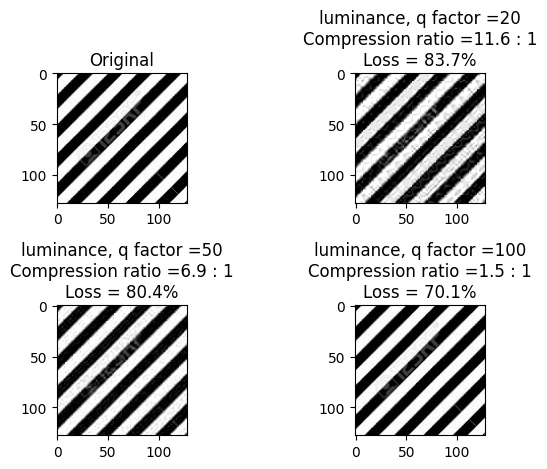

In [111]:
plt.figure()
plt.subplot(2, 2, 1)
sub_image = asarray(img)[0:128,0:128]
plt.title('Original')
plt.imshow(sub_image,cmap='gray')

for i ,q_f  in zip(range(3),[20,50,100])  :
    encoded_stream ,n ,m, huff_table = encode_image(sub_image ,q_type ='luminance' , q_factor=q_f )
    plt.subplot(2, 2, i+2)
    res = decode_image(encoded_stream,n,m ,huff_table ,q_type = 'luminance',q_factor = q_f)
    err = np.sum((sub_image[:,:,1] != res))/(128*128) * 100
    plt.title(
        'luminance, q factor =' + str(q_f) +'\n' +'Compression ratio =' + str(round((n*m*8*64)/len(encoded_stream),1)) +
        ' : 1' + '\n'+'Loss = ' +str(round(err,1))  +'%' )
    plt.imshow( res,cmap='gray')
plt.tight_layout()

##### 2 - Chrominance q table

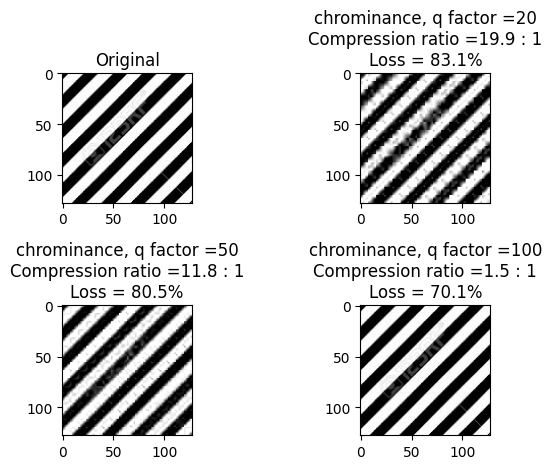

In [112]:
plt.figure()
plt.subplot(2, 2, 1)
plt.title('Original')
sub_image = asarray(img)[0:128,0:128]
plt.imshow(sub_image,cmap='gray')
for i ,q_f  in zip(range(3),[20,50,100])  :
    encoded_stream ,n ,m, huff_table = encode_image(sub_image,q_type ='chrominance' , q_factor=q_f )
    plt.subplot(2, 2, i+2)
    res = decode_image(encoded_stream,n,m ,huff_table ,q_type = 'chrominance',q_factor = q_f)
    err = np.sum((sub_image[:,:,1] != res))/(128*128) * 100
    plt.title(
        'chrominance, q factor =' + str(q_f) +'\n' +'Compression ratio =' + str(round((n*m*8*64)/len(encoded_stream),1)) +
        ' : 1' + '\n'+'Loss = ' +str(round(err,1))  +'%' )
    plt.imshow(res,cmap='gray')
plt.tight_layout()

#### Testing on full image 
##### Table type = luminance , Quality factor = 50

Length of encoded_stream : 560321
Expected image size : 3786752
copression ratio : 6.758183255669518 : 1
Loss =  80.56487459437534 %


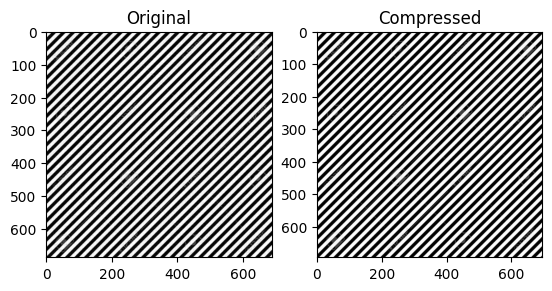

In [115]:
encoded_stream ,n ,m, huff_table= encode_image(asarray(img)) 
print('Length of encoded_stream :' ,len(encoded_stream) )
print('Expected image size :' ,n*m*8*64)
print('copression ratio :' , (n*m*8*64)/len(encoded_stream)  ,': 1')
res = decode_image(encoded_stream,n,m ,huff_table)
err = np.sum(( asarray(img)[0:n*8,0:m*8,1] != res))/(n*m*64) * 100
print('Loss = ', err, '%')
plt.figure()
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(res,cmap='gray')
plt.subplot(1,2,2)
plt.title('Compressed')
plt.imshow(asarray(img) ,cmap='gray') 